In [3]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision

# To view tensorboard metrics
# tensorboard --logdir=logs --port=6006 --bind_all
from torch.utils.tensorboard import SummaryWriter
from functools import partial
from evolver import CrossoverType, MutationType, MatrixEvolver
from unet import UNet
from dataset_utils import PartitionType
from cuda_utils import maybe_get_cuda_device, clear_cuda
from landcover_dataloader import get_landcover_dataloaders

from ignite.contrib.handlers.tensorboard_logger import *
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, ConfusionMatrix, mIoU
from ignite.handlers import ModelCheckpoint
from ignite.utils import setup_logger

# Define directories for data, logging and model saving.
base_dir = os.getcwd()
dataset_name = "landcover_large"
dataset_dir = os.path.join(base_dir, "data/" + dataset_name)
log_dir = os.path.join(base_dir, "logs/" + dataset_name)

# Create DataLoaders for each partition of Landcover data.
dataloader_params = {
    'batch_size': 16,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True}

partition_types = [PartitionType.TRAIN, PartitionType.VALIDATION, 
                   PartitionType.FINETUNING, PartitionType.TEST]
data_loaders = get_landcover_dataloaders(dataset_dir, 
                                         partition_types,
                                         dataloader_params,
                                         force_create_dataset=False)
train_loader = data_loaders[0]
validation_loader = data_loaders[1]

params = {
    'max_epochs': 50,
    'n_classes': 4,
    'in_channels': 4,
    'depth': 4,
    'learning_rate': 0.01,
    'log_steps': 1,
    'save_top_n_models': 3
}


criterion = nn.CrossEntropyLoss()
# Determine metrics for evaluation.
train_metrics = {
        "accuracy": Accuracy(), 
        "loss": Loss(criterion),
        "mean_iou": mIoU(ConfusionMatrix(num_classes = params['n_classes'])),
        }


In [6]:
model_path = os.getcwd() + "/logs/landcover_large/" + "best_model_30_validation_accuracy=0.5027.pt"

model = model = UNet(in_channels = params['in_channels'],
             n_classes = params['n_classes'],
             depth = params['depth'])
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

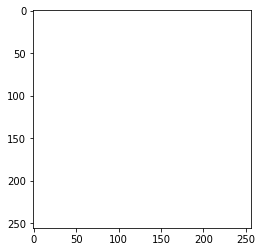

In [79]:
for batch_x, batch_y in train_loader:
    predicts = model(batch_x)
    batch_x = np.moveaxis(batch_x.numpy(), [1], [3])
    plt.figure()
    plt.imshow(batch_x[2])
    plt.show()
    break

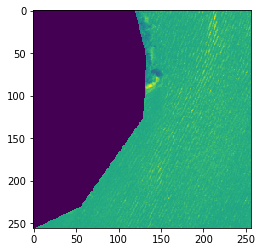

In [95]:
plt.figure()
plt.imshow(batch_x[4, :, :, 0])
plt.show()

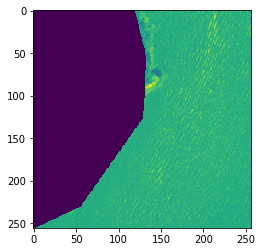

In [96]:
plt.figure()
plt.imshow(batch_x[4, :, :, 1])
plt.show()

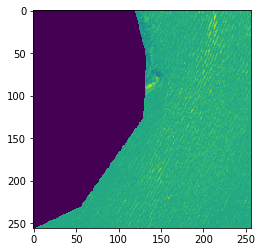

In [97]:
plt.figure()
plt.imshow(batch_x[4, :, :, 2])
plt.show()

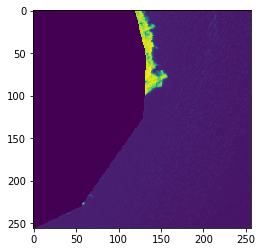

In [98]:
plt.figure()
plt.imshow(batch_x[4, :, :, 3])
plt.show()

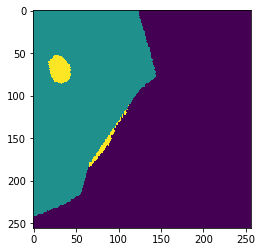

In [100]:
plt.figure()
plt.imshow(batch_y[4])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


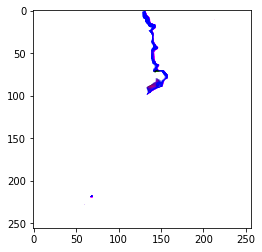

In [104]:
plt.figure()
plt.imshow(np.moveaxis(predicts.detach().numpy(), [1], [3])[4])
plt.show()

In [120]:
from landcover_dataloader import LandCoverDataset
train_set = LandCoverDataset(dataset_dir, PartitionType.FINETUNING)

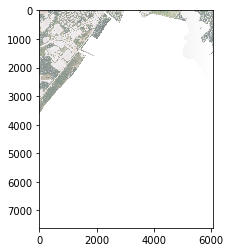

In [121]:
plt.figure()
plt.imshow(np.moveaxis(train_set.tile_x, [0], [2]))
plt.show()

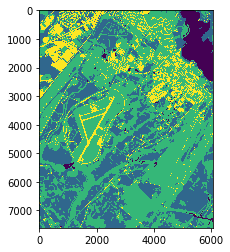

In [122]:
plt.figure()
plt.imshow(train_set.tile_y[0])
plt.show()